In [1]:
from pathlib import Path
import sys
from typing import Dict, List, Optional, Union
from typing_extensions import TypedDict, Literal
from langgraph.graph import StateGraph, START, END
import dotenv
from langchain.chat_models import init_chat_model
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
notebook_dir = Path().absolute()
PROJECT_ROOT = notebook_dir.parent
sys.path.append(str(PROJECT_ROOT))
from RAG_SQL.testSQL import get_review_response
from RAG_PDF.testPDF import get_response

dotenv.load_dotenv()

Response: Bác sĩ Nguyễn Quốc Dũng được đánh giá không tốt về thái độ, cụ thể là lạnh lùng, thiếu đồng cảm và nghiêm khắc, đôi lúc gây khó chịu cho người bệnh.


True

In [2]:
llm = init_chat_model("llama3-70b-8192", model_provider="groq")
router_llm = init_chat_model("llama3-8b-8192", model_provider="groq")

In [3]:
class RouterOutput(BaseModel):
    step: Literal["sql", "pdf", "general"] = Field(
        description="The next step in the routing process"
    )
    confidence: float = Field(
        description="Confidence score between 0.0 and 1.0 for the chosen route",
        ge=0.0,
        le=1.0
    )
    reasoning: str = Field(
        description="Detailed reasoning for why this route was chosen"
    )
    
router = router_llm.with_structured_output(RouterOutput)

In [4]:
class State(TypedDict):
    input: str
    conversation_history: List[Dict[str, str]]
    messages: List
    decision: Dict[str, Union[str, float, str]]
    output: StrOutputParser
    context: Optional[str]
    source: Optional[str]
    fallback_attempts: int

In [5]:
def sql_rag_node(state: State) -> Dict:
    try:
        result = get_review_response(state["messages"])
        if not result or len(result.strip()) < 10:
            return {
                "output": "I couldn't find relevant database information. Would you like me to search our medical documents instead?",
                "source": "sql",
                "fallback_attempts": state.get("fallback_attempts", 0) + 1
            }
        return {
            "output": result,
            "source": "sql",
        }
    except Exception as e:
        return {
            "output": f"I encountered an issue while searching the database. Let me try a different approach.",
            "fallback_attempts": state.get("fallback_attempts", 0) + 1
        }

In [6]:
def pdf_rag_node(state: State) -> Dict:
    try:
        result = get_response(state["messages"])
        if not result or len(result.strip()) < 10:
            return {
                "output": "I couldn't find relevant information in our medical documents. Let me provide a general response.",
                "source": "pdf",
                "fallback_attempts": state.get("fallback_attempts", 0) + 1
            }
        return {
            "output": result,
            "source": "pdf",
        }
    except Exception as e:
        return {
            "output": f"I encountered an issue while searching our medical documents. Let me try a different approach.",
            "fallback_attempts": state.get("fallback_attempts", 0) + 1
        }

In [7]:
def general_qa_node(state: State) -> Dict:
    try:
        messages = [
            SystemMessage(content="You are a helpful AI assistant that maintains conversation context and answers questions accurately and answer me using Vietnamese."),
            *state["messages"]  
        ]
        
        result = llm.invoke(messages)
        
        return {
            "output": result.content,
            "source": "general",
        }
    except Exception as e:
        print(f"Error in general_qa_node: {str(e)}")
        return {
            "output": "I encountered an error processing your request. Could you please rephrase your question?",
            "source": "general"
        }

In [8]:
def router_node(state: State) -> Dict:    
    # Initialize fallback attempts if not present
    if "fallback_attempts" not in state:
        state["fallback_attempts"] = 0
    
    conversation_context = ""
    if state["conversation_history"]:
        conversation_context = "\nRecent conversation history:\n"
        for entry in state["conversation_history"][-3:]:
            conversation_context += f"{entry['role'].capitalize()}: {entry['content']}\n"

    decision = router.invoke(
        [
            SystemMessage(
                content=f"""You are a specialized medical query router. Your task is to analyze the input query and determine the MOST APPROPRIATE processing step. Choose one of:

                - 'sql': For queries about:
                    * Patient reviews and feedback about doctors at (MEDCASE hospital or this hospital)
                    * Doctor performance and ratings based on patient experiences
                    * Doctor ratings and performance evaluations from patients
                    * Patient experiences and satisfaction with MEDCASE doctors
                    * Patient comments and testimonials about specific doctors
                    + Only answer based on the database information.
                    * Examples: 
                        - "What do patients say about Dr. Phuong at MEDCASE?"
                        - "Show me patient reviews for Dr. Hoang at MEDCASE hospital"
                        - "How do patients rate Dr. Linh's service?"
                        - "What is the feedback from patients about Dr. Mai's treatment?"

                - 'pdf': For queries about:
                  * Disease symptoms, treatments, or medical conditions
                  * Healthcare procedures or medical advice
                  * Medical guidelines or protocols
                  * Any queries requiring retrieval from medical documents
                  * Examples: "What are the symptoms of dengue?", "How is malaria treated?"

                - 'general': For queries that are:
                  * Non-medical, casual, or general conversation
                  * Not requiring specific medical data
                  * Follow-up questions about previous responses
                  * Examples: "Thank you", "Can you explain that more simply?"

                Focus on the core content of the query and ignore greetings or polite phrases. 
                Select the most appropriate step based on the query's intent and content.
                Provide a confidence score between 0 and 1.
                {state['conversation_history']}
                """
            ),
            HumanMessage(content=state["input"]),
        ]
    )
    
    return {"decision": {
        "step": decision.step,
        "confidence": decision.confidence,
        "reasoning": decision.reasoning
    }}

In [9]:
def fallback_router(state: State) -> str:
    if state.get("fallback_attempts", 0) >= 2:
        return "General"  # After 2 failed attempts, go to general QA
    
    # Check if we've already tried the current source
    if state.get("source") == "sql":
        return "Pdf"
    elif state.get("source") == "pdf":
        return "General"
    
    # Default routing
    decision = state["decision"]["step"]
    confidence = state["decision"]["confidence"]
    
    # Low confidence routing
    if confidence < 0.7:
        if decision == "sql":
            if "database" in state["input"].lower() or "doctor" in state["input"].lower():
                return "Sql"
            else:
                return "Pdf"
        elif decision == "pdf":
            if "disease" in state["input"].lower() or "symptom" in state["input"].lower():
                return "Pdf"
            else:
                return "General"
    
    # High confidence routing
    if decision == "sql":
        return "Sql"
    elif decision == "pdf":
        return "Pdf"
    else:
        return "General"

In [10]:
router_builder = StateGraph(State)

router_builder.add_node("Router", router_node)
router_builder.add_node("Sql", sql_rag_node)
router_builder.add_node("Pdf", pdf_rag_node)
router_builder.add_node("General", general_qa_node)

router_builder.add_edge(START, "Router")
router_builder.add_conditional_edges(
    "Router",
    fallback_router,
    {
        "Sql": "Sql",
        "Pdf": "Pdf",
        "General": "General",
    },
)

router_builder.add_conditional_edges(
    "Sql",
    lambda state: "Router" if state.get("fallback_attempts", 0) > 0 else END,
    {
        "Router": "Router",
        END: END
    }
)
router_builder.add_conditional_edges(
    "Pdf",
    lambda state: "Router" if state.get("fallback_attempts", 0) > 0 else END,
    {
        "Router": "Router",
        END: END
    }
)
router_builder.add_edge("General", END)
router_workflow = router_builder.compile()

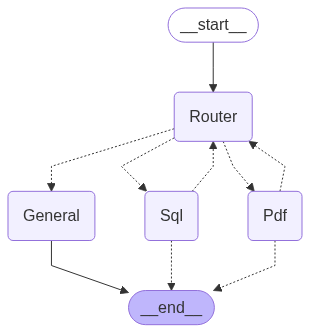

In [11]:
from IPython.display import Image, display

display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [16]:
history = [
    # {"role": "user", "content": "tôi cho số bí mật là 175003 bạn nhớ chưa?"},
    # {"role": "assistant", "content": "I remember! Your secret number is 175003.", "source": "general"},
    # {"role": "user", "content": "Số bí mật tôi vừa nói là gì và tính xem 1 + 1 = mấy ?"},
    # {"role": "assistant", "content": "I remember! Your secret number is 175003. And, of course, 1 + 1 = 2"},
    # {"role": "user",      "content": "Những bệnh nhân nói gì về bác sĩ John Doe trong bệnh viện này"},
    # {"role": "assistant", "content": "Từ các đánh giá và phản hồi của bệnh nhân, bác sĩ John Doe tại bệnh viện này được đánh giá cao về tính chuyên nghiệp," + 
    # "thái độ thân thiện và kỹ năng chẩn đoán bệnh chính xác. Một số bệnh nhân đã chia sẻ rằng bác sĩ John Doe đã dành thời gian để lắng nghe và trả lời các câu" + 
    # "hỏi của họ, khiến họ cảm thấy an toàn và tin tưởng. Ngoài ra, bác sĩ Doe cũng được biết đến với khả năng giải thích các vấn đề sức khỏe một cách rõ ràng và" + 
    # "dễ hiểu, giúp bệnh nhân có thể hiểu và tuân thủ các hướng dẫn điều trị. Tuy nhiên, một số bệnh nhân cũng đã nêu ra một số vấn đề nhỏ, chẳng hạn như thời gian" + 
    # "chờ đợi lâu hoặc khó có thể liên hệ với bác sĩ Doe sau giờ làm việc. Tuy nhiên, nhìn chung, đa số bệnh nhân đều rất hài lòng với dịch vụ y tế của bác sĩ John Doe" + 
    # "tại bệnh viện này"},
    # {"role": "user", "content": "Bác sĩ Nguyễn Quốc Dũng trong bệnh viện MEDCASE được bệnh nhân đánh giá như nào ?, trả lời chính xác dựa trên thông tin được lưu trong SQL"},
    {"role": "user", "content": "Bác sĩ Nguyễn Quốc Dũng trong bệnh viện MEDCASE được bệnh nhân đánh giá như nào ?"},
]
messages = []
for entry in history:
    if entry["role"] == "user":
        messages.append(HumanMessage(content=entry["content"]))
    else:
        messages.append(AIMessage(content=entry["content"]))

print(messages)

[HumanMessage(content='Bác sĩ Nguyễn Quốc Dũng trong bệnh viện MEDCASE được bệnh nhân đánh giá như nào ?', additional_kwargs={}, response_metadata={})]


In [17]:
state = router_workflow.invoke({
    "input": history[-1]["content"],
    "conversation_history": history,
    "messages": messages
})
print(f"Decision: {state['decision']['step']} (Confidence: {state['decision']['confidence']})")
print(f"Reasoning: {state['decision']['reasoning']}")
print(f"Output: {state['output']}")

Decision: sql (Confidence: 1.0)
Reasoning: The query is asking about patient reviews and feedback about a doctor at MEDCASE hospital, which is a suitable use case for the 'sql' step.
Output: Theo phản hồi của bệnh nhân, bác sĩ Nguyễn Quốc Dũng có thái độ làm việc tốt nhưng quá nghiêm khắc, đôi lúc gây khó chịu cho bệnh, cần cải thiện thái độ hơn nữa. Ngoài ra, một bệnh nhân khác cũng cho rằng bác sĩ này có thái độ lạnh lùng và thiếu sự đồng cảm, làm bệnh nhân cảm thấy mình như một con số hơn là một con người cần được chữa trị.


In [18]:
result = sql_rag_node(state)
print(f"Output: {result}")

Output: {'output': 'Theo phản hồi của các bệnh nhân, bác sĩ Nguyễn Quốc Dũng được đánh giá là có thái độ làm việc tốt, nhưng lại quá nghiêm khắc, đôi lúc gây khó chịu cho bệnh, cần cải thiện thái độ hơn nữa. Además, một bệnh nhân khác cho rằng bác sĩ này có thái độ lạnh lùng và thiếu sự đồng cảm, làm người bệnh cảm thấy mình như một con số hơn là một con người cần được chữa trị.', 'source': 'sql'}


In [19]:
result = get_review_response(messages)
print(result)

Theo phản hồi của các bệnh nhân, Bác sĩ Nguyễn Quốc Dũng được đánh giá là có thái độ làm việc tốt nhưng lại lạnh lùng, nghiêm khắc, đôi lúc ngây khó chịu cho người bệnh, cần cải thiện thái độ hơn nữa.
